# **Country Development**

We are going to create an unsupervised model based on the country's statistics on its development.

In this notebook we aim to:

- Perform Exploratory Data Analysis
- Data Cleaning, if necessary
- Train the model with KMeans, DBSCAN, and Spectral Clustering

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
df = pd.read_csv('./Country-data.csv')
info = pd.read_csv('./data-dictionary.csv')

In [61]:
# info about the data and its columns
info.head(10)

Column Name                                        Description
0     country                                Name of the country
1  child_mort  Death of children under 5 years of age per 100...
2     exports  Exports of goods and services per capita. Give...
3      health  Total health spending per capita. Given as %ag...
4     imports  Imports of goods and services per capita. Give...
5      Income                              Net income per person
6   Inflation  The measurement of the annual growth rate of t...
7  life_expec  The average number of years a new born child w...
8   total_fer  The number of children that would be born to e...
9        gdpp  The GDP per capita. Calculated as the Total GD...

In [62]:
df.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


We are dealing mostly with continous variables. Except for the `country` feature.

<Figure size 1000x800 with 0 Axes>

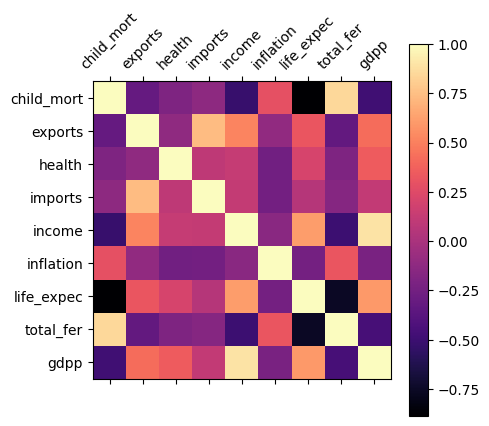

In [64]:
# Let's see any correlation so we can precisely choose our plotting
corr = df.drop('country', axis=1).corr()
plt.figure(figsize=(10,8))
plt.matshow(corr, cmap='magma')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

In the correlation matrix above,  we can see the highly correlated features:

- `gdpp` vs `life_expec`
- `total_fer` vs `child_mort`
- `total_fer` vs `inflation`
- `life_expec` vs `income`
- `exports` vs `imports`
- `income` vs `gdpp`
- `income` vs `exports`

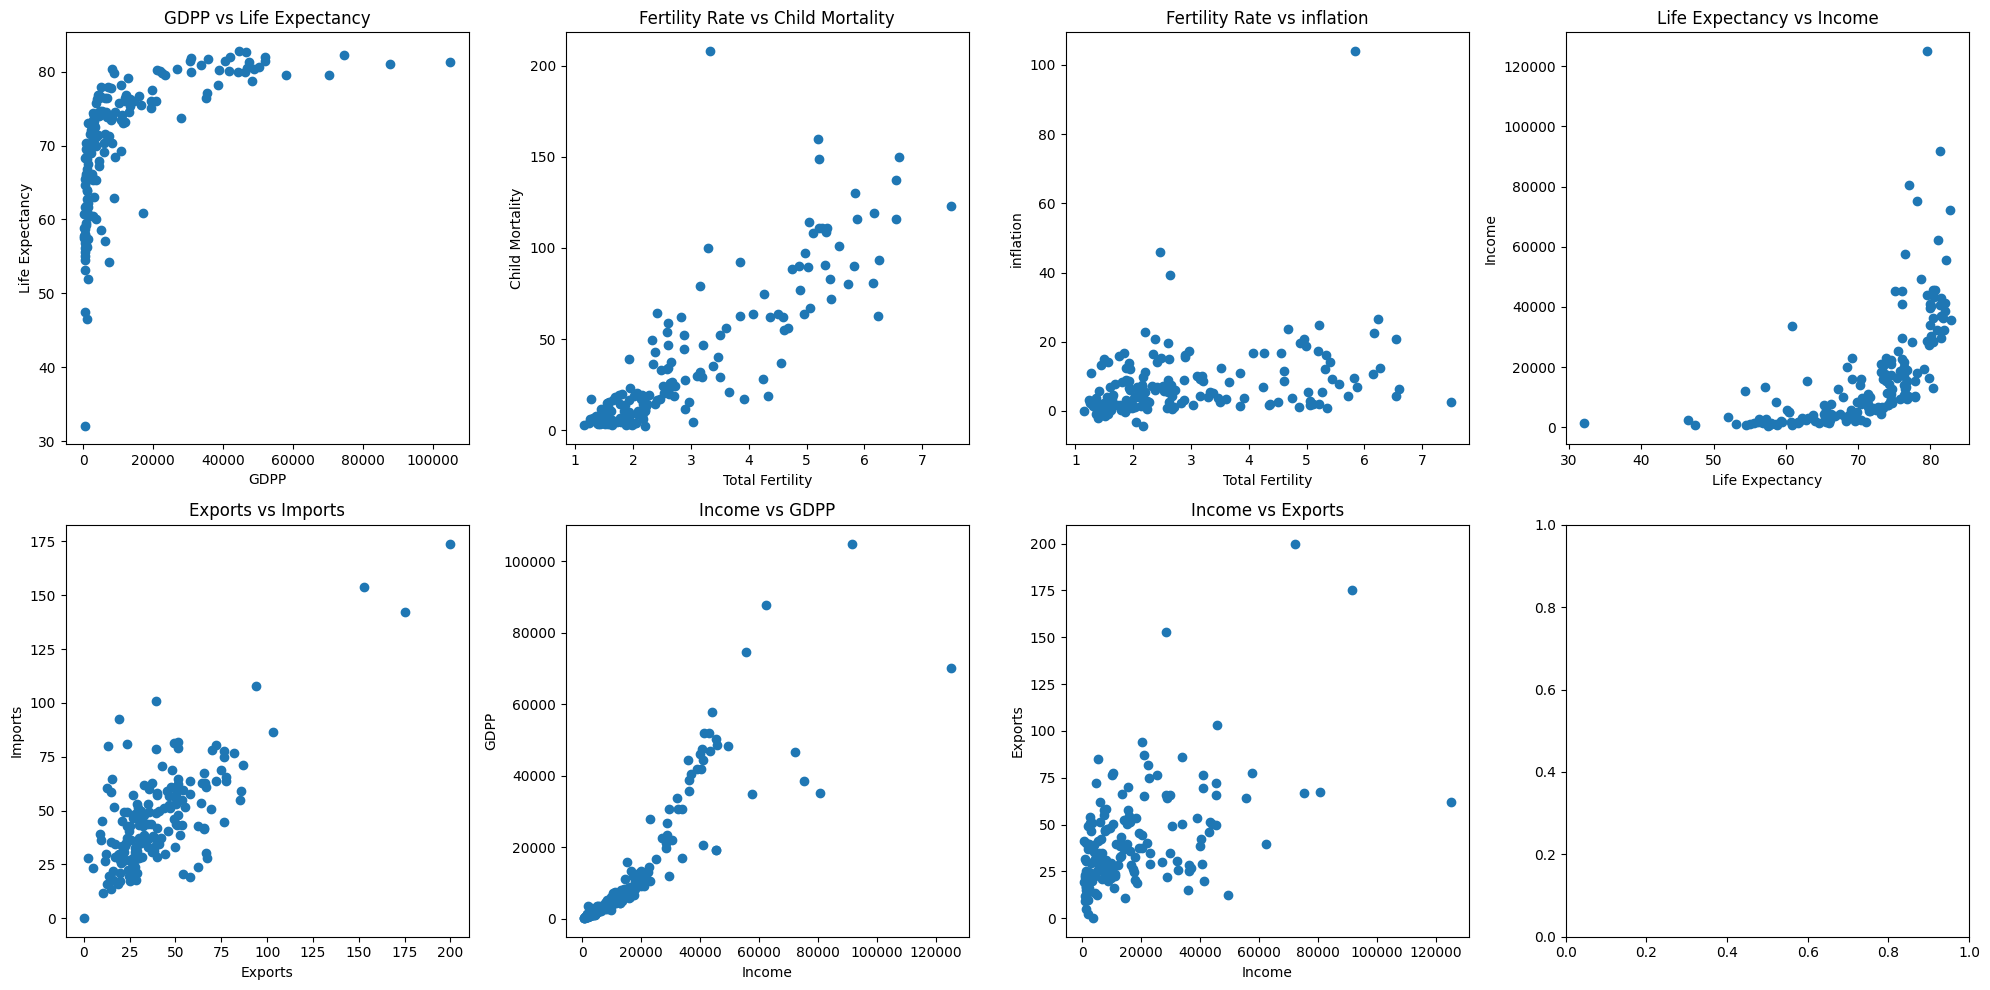

In [65]:
# plots

fig, axes = plt.subplots(2, 4, figsize=(20,10))

# gdpp vs life expec
axes[0,0].scatter(df['gdpp'], df['life_expec'])
axes[0,0].set_xlabel('GDPP')
axes[0,0].set_ylabel('Life Expectancy')
axes[0,0].set_title('GDPP vs Life Expectancy')

axes[0,1].scatter(df['total_fer'], df['child_mort'])
axes[0,1].set_xlabel('Total Fertility')
axes[0,1].set_ylabel('Child Mortality')
axes[0,1].set_title('Fertility Rate vs Child Mortality')

axes[0,2].scatter(df['total_fer'], df['inflation'])
axes[0,2].set_xlabel('Total Fertility')
axes[0,2].set_ylabel('inflation')
axes[0,2].set_title('Fertility Rate vs inflation')

axes[0,3].scatter(df['life_expec'], df['income'])
axes[0,3].set_xlabel('Life Expectancy')
axes[0,3].set_ylabel('Income')
axes[0,3].set_title('Life Expectancy vs Income')

axes[1,0].scatter(df['exports'], df['imports'])
axes[1,0].set_xlabel('Exports')
axes[1,0].set_ylabel('Imports')
axes[1,0].set_title('Exports vs Imports')

axes[1,1].scatter(df['income'], df['gdpp'])
axes[1,1].set_xlabel('Income')
axes[1,1].set_ylabel('GDPP')
axes[1,1].set_title('Income vs GDPP')

axes[1,2].scatter(df['income'], df['exports'])
axes[1,2].set_xlabel('Income')
axes[1,2].set_ylabel('Exports')
axes[1,2].set_title('Income vs Exports')

plt.tight_layout()
plt.show()

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [67]:
# checking for NaN vals
df.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

No data cleaning needed. We can now perform PCA with our data.

In [68]:
# label encoding on country column
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
country_labels = encoder.fit_transform(df['country'].values)

In [69]:
df['country'] = country_labels
df.head()

country  child_mort  exports  health  imports  income  inflation  \
0        0        90.2     10.0    7.58     44.9    1610       9.44   
1        1        16.6     28.0    6.55     48.6    9930       4.49   
2        2        27.3     38.4    4.17     31.4   12900      16.10   
3        3       119.0     62.3    2.85     42.9    5900      22.40   
4        4        10.3     45.5    6.03     58.9   19100       1.44   

   life_expec  total_fer   gdpp  
0        56.2       5.82    553  
1        76.3       1.65   4090  
2        76.5       2.89   4460  
3        60.1       6.16   3530  
4        76.8       2.13  12200

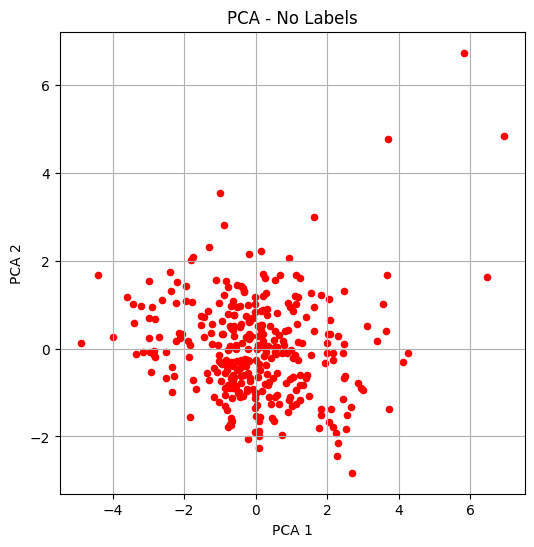

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

pca = PCA(n_components=5)
df_pca = pca.fit_transform(scaled_df)

plt.figure(figsize=(6,6))
plt.scatter(df_pca[:, 0], df_pca[:,1], color='red', s=20)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.title('PCA - No Labels')

plt.show()

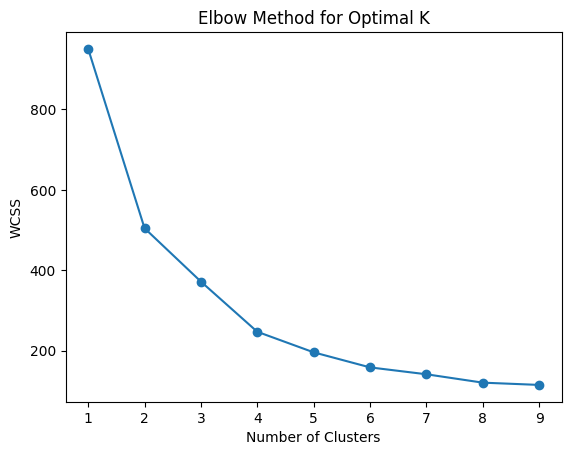

In [13]:
from sklearn.cluster import KMeans

plot_range = range(1, 10)

km_inertia = []

for i in plot_range:
    km = KMeans(n_clusters=i)
    km.fit(df_pca)
    km_inertia.append(km.inertia_)
    
plt.plot(plot_range, km_inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

We can start with 4 clusters

Silhouette Score of K-Means: 0.39494925962465827


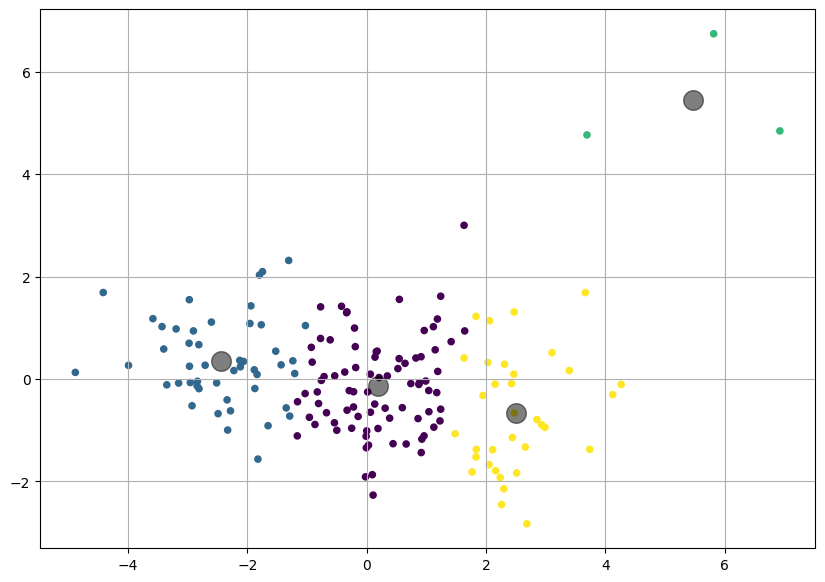

In [ ]:
from sklearn.metrics import silhouette_score

km = KMeans(n_clusters=4)
km.fit(df_pca)
y_kmeans = km.predict(df_pca)

# plot clusters
centeroids = km.cluster_centers_

print(f'Silhouette Score of K-Means: {silhouette_score(df_pca, y_kmeans)}')

plt.figure(figsize=(10,7))
plt.scatter(df_pca[:, 0], df_pca[:, 1], s=20, c=y_kmeans, cmap='viridis')
plt.scatter(centeroids[:,0], centeroids[:,1], s=200, c='black', alpha=0.5)
plt.grid(True)
plt.show()

Silhouette Score of DBSCAN: 0.07181823151547449


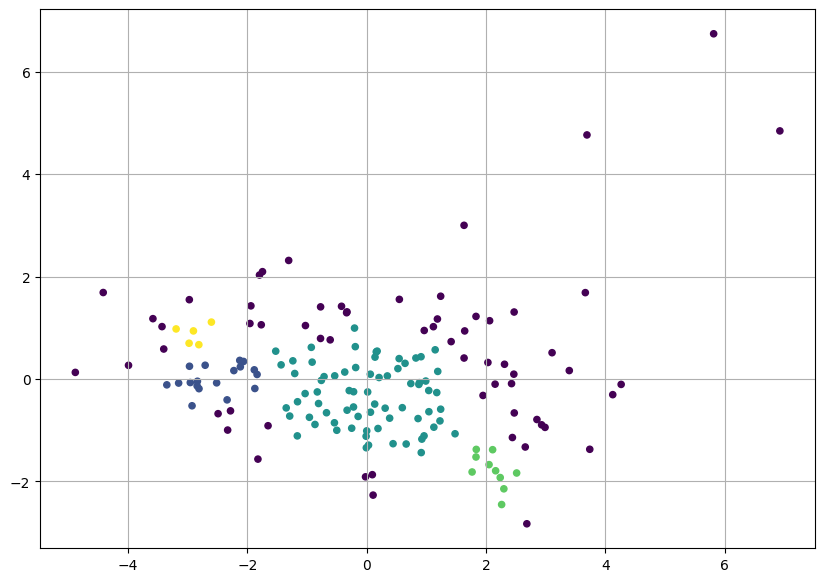

In [ ]:
# training a DBSCAN model
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=0.4, min_samples=5)
dbs.fit(df_pca)
dbs_labels = dbs.labels_

print(f'Silhouette Score of DBSCAN: {silhouette_score(df_pca, dbs_labels)}')

plt.figure(figsize=(10,7))
plt.scatter(df_pca[:, 0], df_pca[:, 1], s=20, c=dbs_labels, cmap='viridis')
plt.grid(True)
plt.show()

Silhouette Score of Spectral Clustering: 0.3189576759025352


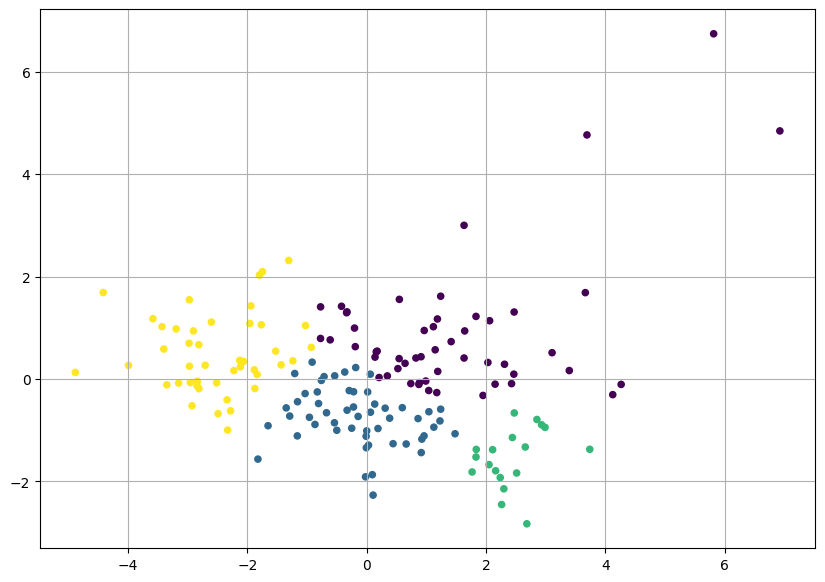

In [38]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', assign_labels='kmeans')
sc_labels = sc.fit_predict(df_pca)

print(f'Silhouette Score of Spectral Clustering: {silhouette_score(df_pca, sc_labels)}')

plt.figure(figsize=(10,7))
plt.scatter(df_pca[:, 0], df_pca[:, 1], s=20, c=sc_labels, cmap='viridis')
plt.grid(True)
plt.show()

In [55]:
df.head()

country  child_mort  exports  health  imports  income  inflation  \
0        0        90.2     10.0    7.58     44.9    1610       9.44   
1        1        16.6     28.0    6.55     48.6    9930       4.49   
2        2        27.3     38.4    4.17     31.4   12900      16.10   
3        3       119.0     62.3    2.85     42.9    5900      22.40   
4        4        10.3     45.5    6.03     58.9   19100       1.44   

   life_expec  total_fer   gdpp  
0        56.2       5.82    553  
1        76.3       1.65   4090  
2        76.5       2.89   4460  
3        60.1       6.16   3530  
4        76.8       2.13  12200

In [44]:
sample = np.array([[4, 12.5, 76.2, 15.8, 12.5, 38000, 1.55, 87.3, 5.22, 5000]])
scaled_input = scaler.transform(sample)
scaled_input_data = pca.transform(scaled_input)

c:\Users\admin\Desktop\Classes\2nd sem\Intelligent Systems\HF Spaces\Country_Development\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [57]:
type(scaled_input_data[0])

numpy.ndarray

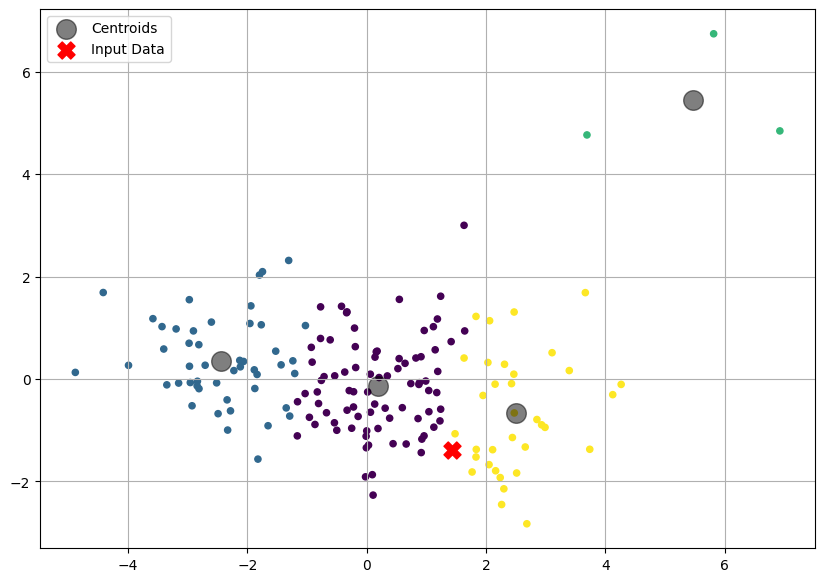

In [ ]:
# 
single_point = scaled_input_data[0]

plt.figure(figsize=(10,7))
plt.scatter(df_pca[:, 0], df_pca[:, 1], s=20, c=y_kmeans, cmap='viridis')
plt.scatter(centeroids[:,0], centeroids[:,1], s=200, c='black', alpha=0.5, label='Centroids')
plt.scatter(single_point[0], single_point[1], s=150, c='red', marker='X', label='Input Data')
plt.grid(True)
plt.legend()
plt.show()